<a href="https://colab.research.google.com/github/FacuRoffet99/ML/blob/main/TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 7: Señales camineras**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPool2D, Flatten, Dense, Dropout

## Archivos


In [2]:
# Descargar archivos
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

--2021-10-11 21:34:04--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip’

data_1.zip          100%[===================>]  30.59M   141MB/s    in 0.2s    

2021-10-11 21:34:06 (141 MB/s) - ‘dataroot/data_1.zip’ saved [32074743/32074743]

--2021-10-11 21:34:06--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.19

In [3]:
# Descomprimir archivos
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

## Datos

In [4]:
# Cargar las imágenes 
import pickle
train = pickle.load( open( dataroot+"train.p", "rb" ) )
valid = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

In [5]:
# División en datos y labels
X_train, y_train = train["features"], train["labels"]
X_valid, y_valid = valid["features"], valid["labels"]
X_test, y_test = test["features"], test["labels"]

In [6]:
# Cargar nombres de las señales 
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()

The image shows a Speed limit (80km/h) sign


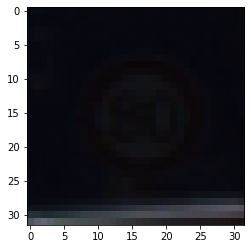

In [7]:
# Ver imagen
i = np.random.randint(0,len(X_train))
plt.imshow(X_train[i])
print("The image shows a {} sign".format(signnames[y_train[i]]))

## Modelo SVM
Se logra una accuracy del 79%, lo cual es aceptable considerando que se trata de un modelo que trata a las imágenes como vectores.

In [ ]:
# Cantidades de imágenes
n_samples_train = len(X_train)
n_samples_test = len(X_test)

# Matrices aplanadas
X_train_plain = X_train.reshape((n_samples_train, -1))
X_test_plain = X_test.reshape((n_samples_test, -1))

In [ ]:
# Uso LinearSVC porque SVC tarda mucho con esta cantidad de datos
classifier = svm.LinearSVC()

# Entrenamiento (tarda 20 minutos)
classifier.fit(X_train_plain, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
# Predicciones y métricas
y_predicted = classifier.predict(X_test_plain)
print("Classification report for classifier {}\n{}\n".format(classifier, metrics.classification_report(y_test, y_predicted)))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
              precision    recall  f1-score   support

           0       0.44      0.13      0.21        60
           1       0.76      0.71      0.73       720
           2       0.68      0.79      0.73       750
           3       0.45      0.87      0.59       450
           4       0.64      0.81      0.72       660
           5       0.72      0.63      0.67       630
           6       0.83      0.73      0.77       150
           7       0.71      0.68      0.70       450
           8       0.76      0.81      0.78       450
           9       0.91      0.81      0.85       480
          10       0.92      0.94      0.93       660
          11       0.89      0.84      0.86       420
          12       0.98      0

## Modelo convolucional Kaggle
Este modelo fue tomado completamente de Kaggle. Se trata de una red neuronal con capas convolucionales, las cuáles son mucho mejores para trabajar con imágenes. Además utiliza dropout para evitar overfitting. El resultado es una accuracy del 89%, que presenta una gran mejora con respecto al modelo anterior.

In [ ]:
# Construcción de la red neuronal convolucional
cnn = Sequential()

cnn.add(Conv2D(filters=16,  kernel_size=3, activation="relu",input_shape=(32,32,3)))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(filters=64, activation="relu",kernel_size=3))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Flatten())

cnn.add(Dense(units=512,activation="relu"))
cnn.add(Dropout(0.2))

cnn.add(Dense(units=43,activation="softmax"))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [ ]:
# Compilar la red
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Entrenar a la red
history = cnn.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs=10, batch_size=500)

Epoch 1/10
70/70 [==============================] - 40s 539ms/step - loss: 10.1508 - accuracy: 0.2522 - val_loss: 1.8995 - val_accuracy: 0.5195
Epoch 2/10
70/70 [==============================] - 28s 405ms/step - loss: 1.2077 - accuracy: 0.6504 - val_loss: 1.0741 - val_accuracy: 0.7020
Epoch 3/10
70/70 [==============================] - 29s 408ms/step - loss: 0.5981 - accuracy: 0.8238 - val_loss: 0.7549 - val_accuracy: 0.8113
Epoch 4/10
70/70 [==============================] - 31s 448ms/step - loss: 0.3813 - accuracy: 0.8901 - val_loss: 0.7270 - val_accuracy: 0.8311
Epoch 5/10
70/70 [==============================] - 31s 430ms/step - loss: 0.2633 - accuracy: 0.9238 - val_loss: 0.6126 - val_accuracy: 0.8533
Epoch 6/10
70/70 [==============================] - 29s 412ms/step - loss: 0.2001 - accuracy: 0.9430 - val_loss: 0.6481 - val_accuracy: 0.8680
Epoch 7/10
70/70 [==============================] - 29s 407ms/step - loss: 0.1544 - accuracy: 0.9565 - val_loss: 0.6516 - val_accuracy: 0.866

In [ ]:
# Predicciones y métricas
predictions = np.argmax(cnn.predict(X_test),axis=1)
print("Classification report for classifier {}\n{}\n".format(cnn, metrics.classification_report(y_test, predictions)))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f9534acaed0>
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        60
           1       0.78      0.98      0.87       720
           2       0.92      0.88      0.90       750
           3       0.88      0.83      0.86       450
           4       0.91      0.87      0.89       660
           5       0.76      0.78      0.77       630
           6       0.97      0.77      0.86       150
           7       0.80      0.84      0.82       450
           8       0.87      0.76      0.81       450
           9       0.94      0.94      0.94       480
          10       0.99      0.95      0.97       660
          11       0.85      0.90      0.88       420
          12       0.96      0.94      0.95       690
          13       0.99      0.98      0.98       720
          14       0.96      1.00      0.98       270
          15       0.97      0.98   

## Modelo convolucional propio
Edité al modelo anterior al agregarle dos nuevas capas convolucionales para ver si se podían mejorar incluso más los resultados. La accuracy subió al 94%, por lo que se logró el objetivo.//

También probé agregando data augmentation, cambiando el learning rate y poniendo padding a las capas convolucionales. Sin embargo, no pude obtener una mejora así que no incluyo dichas variantes en este notebook.

In [23]:
# Construcción de la red neuronal convolucional
cnn = Sequential()

cnn.add(Conv2D(filters=16, kernel_size=3, activation="relu",input_shape=(32,32,3)))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(filters=64, activation="relu",kernel_size=3))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(filters=128, activation="relu",kernel_size=3))
cnn.add(Conv2D(filters=256, activation="relu",kernel_size=3))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Flatten())

cnn.add(Dense(units=512,activation="relu"))
cnn.add(Dropout(0.2))

cnn.add(Dense(units=43,activation="softmax"))

cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 128)        

In [25]:
# Compilar la red
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# Entrenar la red
history = cnn.fit(X_train,y_train, validation_data=(X_valid,y_valid), epochs=10, batch_size=500)

Epoch 1/10
70/70 [==============================] - 56s 794ms/step - loss: 4.5591 - accuracy: 0.1759 - val_loss: 2.3485 - val_accuracy: 0.3705
Epoch 2/10
70/70 [==============================] - 54s 779ms/step - loss: 1.5814 - accuracy: 0.5436 - val_loss: 1.2181 - val_accuracy: 0.6612
Epoch 3/10
70/70 [==============================] - 54s 778ms/step - loss: 0.8081 - accuracy: 0.7622 - val_loss: 0.6672 - val_accuracy: 0.8390
Epoch 4/10
70/70 [==============================] - 55s 788ms/step - loss: 0.4604 - accuracy: 0.8641 - val_loss: 0.3726 - val_accuracy: 0.9079
Epoch 5/10
70/70 [==============================] - 55s 782ms/step - loss: 0.3195 - accuracy: 0.9085 - val_loss: 0.3176 - val_accuracy: 0.9222
Epoch 6/10
70/70 [==============================] - 55s 781ms/step - loss: 0.2406 - accuracy: 0.9311 - val_loss: 0.2807 - val_accuracy: 0.9356
Epoch 7/10
70/70 [==============================] - 55s 784ms/step - loss: 0.1754 - accuracy: 0.9494 - val_loss: 0.2344 - val_accuracy: 0.9424

In [27]:
# Predicciones y métricas
predictions = np.argmax(cnn.predict(X_test),axis=1)
print("Classification report for classifier {}\n{}\n".format(cnn, metrics.classification_report(y_test, predictions)))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f8166860cd0>
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        60
           1       0.92      0.98      0.95       720
           2       0.94      0.96      0.95       750
           3       0.88      0.92      0.90       450
           4       0.99      0.93      0.96       660
           5       0.88      0.88      0.88       630
           6       0.99      0.81      0.89       150
           7       0.94      0.87      0.90       450
           8       0.91      0.97      0.94       450
           9       0.94      0.98      0.96       480
          10       0.98      0.99      0.99       660
          11       0.91      0.99      0.95       420
          12       0.98      0.96      0.97       690
          13       1.00      0.99      1.00       720
          14       1.00      1.00      1.00       270
          15       0.95      0.99   